In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import shap
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


# 1.Loading and checking the dataset

In [3]:
training_data = pd.read_csv("D:\\virtual_experience\\bcg\\ml_case_training_data.csv")
churn_data =pd.read_csv("D:\\virtual_experience\\bcg\\ml_case_training_output.csv")
history_data =pd.read_csv("D:\\virtual_experience\\bcg\\ml_case_training_hist_data.csv")

In [4]:
#show the first 5 rows in each csv file
training_data.head(5)

,id,activity_new,campaign_disc_ele,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_first_activ,...,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max
0,48ada52261e7cf58715202705a0451c9,esoiiifxdlbkcsluxmfuacbdckommixw,NaN,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,2012-11-07,2016-11-06,NaN,...,58.995952,f,831.8,-41.76,-41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.000
1,24011ae4ebbe3035111d65fa7c15bc57,NaN,NaN,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,NaN,...,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648
2,d29c2c54acc38ff3c0614d0a653813dd,NaN,NaN,NaN,4660,0,0,2009-08-21,2016-08-30,NaN,...,44.311378,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800
3,764c75f661154dac3a6c254cd082ea7d,NaN,NaN,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,NaN,...,44.311378,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856
4,bba03439a292a1e166f80264c16191cb,NaN,NaN,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,NaN,...,44.311378,f,0.0,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200


In [5]:
churn_data.head(5)

,id,churn
0,48ada52261e7cf58715202705a0451c9,0
1,24011ae4ebbe3035111d65fa7c15bc57,1
2,d29c2c54acc38ff3c0614d0a653813dd,0
3,764c75f661154dac3a6c254cd082ea7d,0
4,bba03439a292a1e166f80264c16191cb,0


In [6]:
history_data.head(5)

,id,price_date,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [7]:
#merge two dataset on the common attritube "id"
df = pd.merge(training_data,churn_data, on="id")
df.head(5)

,id,activity_new,campaign_disc_ele,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_first_activ,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,48ada52261e7cf58715202705a0451c9,esoiiifxdlbkcsluxmfuacbdckommixw,NaN,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,2012-11-07,2016-11-06,NaN,...,f,831.8,-41.76,-41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.000,0
1,24011ae4ebbe3035111d65fa7c15bc57,NaN,NaN,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,NaN,...,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
2,d29c2c54acc38ff3c0614d0a653813dd,NaN,NaN,NaN,4660,0,0,2009-08-21,2016-08-30,NaN,...,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
3,764c75f661154dac3a6c254cd082ea7d,NaN,NaN,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,NaN,...,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
4,bba03439a292a1e166f80264c16191cb,NaN,NaN,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,NaN,...,f,0.0,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0


# 2. General EDA on the dataset

In [8]:
#checking the datatype for each column
df.info(verbose =True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16096 entries, 0 to 16095
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        16096 non-null  object 
 1   activity_new              6551 non-null   object 
 2   campaign_disc_ele         0 non-null      float64
 3   channel_sales             11878 non-null  object 
 4   cons_12m                  16096 non-null  int64  
 5   cons_gas_12m              16096 non-null  int64  
 6   cons_last_month           16096 non-null  int64  
 7   date_activ                16096 non-null  object 
 8   date_end                  16094 non-null  object 
 9   date_first_activ          3508 non-null   object 
 10  date_modif_prod           15939 non-null  object 
 11  date_renewal              16056 non-null  object 
 12  forecast_base_bill_ele    3508 non-null   float64
 13  forecast_base_bill_year   3508 non-null   float64
 14  foreca

In [9]:
#information on the history_data
history_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            193002 non-null  object 
 1   price_date    193002 non-null  object 
 2   price_p1_var  191643 non-null  float64
 3   price_p2_var  191643 non-null  float64
 4   price_p3_var  191643 non-null  float64
 5   price_p1_fix  191643 non-null  float64
 6   price_p2_fix  191643 non-null  float64
 7   price_p3_fix  191643 non-null  float64
dtypes: float64(6), object(2)
memory usage: 11.8+ MB


In [10]:
# finding the general information on all numerical columns for combined dataset
df.describe()

,campaign_disc_ele,cons_12m,cons_gas_12m,cons_last_month,forecast_base_bill_ele,forecast_base_bill_year,forecast_bill_12m,forecast_cons,forecast_cons_12m,forecast_cons_year,...,forecast_price_energy_p2,forecast_price_pow_p1,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn
count,0.0,1.609600e+04,1.609600e+04,1.609600e+04,3508.000000,3508.000000,3508.000000,3508.000000,16096.000000,16096.000000,...,15970.000000,15970.000000,16096.000000,16083.000000,16083.000000,16096.000000,16081.000000,16096.000000,16093.000000,16096.000000
mean,NaN,1.948044e+05,3.191164e+04,1.946154e+04,335.843857,335.843857,3837.441866,206.845165,2370.555949,1907.347229,...,0.052951,43.533496,196.123447,22.462276,21.460318,1.347788,217.987028,5.030629,20.604131,0.099093
std,NaN,6.795151e+05,1.775885e+05,8.235676e+04,649.406000,649.406000,5425.744327,455.634288,4035.085664,5257.364759,...,0.048617,5.212252,494.366979,23.700883,27.917349,1.459808,366.742030,1.676101,21.772421,0.298796
min,NaN,-1.252760e+05,-3.037000e+03,-9.138600e+04,-364.940000,-364.940000,-2503.480000,0.000000,-16689.260000,-85627.000000,...,0.000000,-0.122184,-9038.210000,-525.540000,-615.660000,1.000000,-4148.990000,1.000000,1.000000,0.000000
25%,NaN,5.906250e+03,0.000000e+00,0.000000e+00,0.000000,0.000000,1158.175000,0.000000,513.230000,0.000000,...,0.000000,40.606701,0.000000,11.960000,11.950000,1.000000,51.970000,4.000000,12.500000,0.000000
50%,NaN,1.533250e+04,0.000000e+00,9.010000e+02,162.955000,162.955000,2187.230000,42.215000,1179.160000,378.000000,...,0.086163,44.311378,44.465000,21.090000,20.970000,1.000000,119.680000,5.000000,13.856000,0.000000
75%,NaN,5.022150e+04,0.000000e+00,4.127000e+03,396.185000,396.185000,4246.555000,228.117500,2692.077500,1994.250000,...,0.098837,44.311378,218.090000,29.640000,29.640000,1.000000,275.810000,6.000000,19.800000,0.000000
max,NaN,1.609711e+07,4.188440e+06,4.538720e+06,12566.080000,12566.080000,81122.630000,9682.890000,103801.930000,175375.000000,...,0.195975,59.444710,15042.790000,374.640000,374.640000,32.000000,24570.650000,16.000000,500.000000,1.000000


__Problem observed:__  
__First:__ For some of the companies, they are getting negative values for gas and energy, most likely they are incorrect value, and they will be dealt with later on
__Second:__ Somehow the first column shows nothing while in csv file, there are string values there, not sure what to do with them for now



In [11]:
#finding the general information on all numerical columns for history data
history_data.describe()

,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
count,191643.000000,191643.000000,191643.000000,191643.000000,191643.000000,191643.000000
mean,0.140991,0.054412,0.030712,43.325546,10.698201,6.455436
std,0.025117,0.050033,0.036335,5.437952,12.856046,7.782279
min,0.000000,0.000000,0.000000,-0.177779,-0.097752,-0.065172
25%,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,0.146033,0.085483,0.000000,44.266930,0.000000,0.000000
75%,0.151635,0.101780,0.072558,44.444710,24.339581,16.226389
max,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221


__Problem observed:__    
__First:__ there are negative values for price which is not correct, might need to change them to positive value later 


## Deal with Missing Value

In [12]:
#check the number of missing value,convert them to percentage, and find the column with over 70 percent of the missing value in churn dataset 
percentage_missing = df.isnull().sum()*100/len(df)
missing_value_df = pd.DataFrame({"columns":df.columns,"missing value percentage": percentage_missing})
rm_columns=missing_value_df[missing_value_df["missing value percentage"]>70].index.tolist()
rm_columns

['campaign_disc_ele',
 'date_first_activ',
 'forecast_base_bill_ele',
 'forecast_base_bill_year',
 'forecast_bill_12m',
 'forecast_cons']

In [13]:
#check the number of missing value,convert them to percentage, and find the column with over 70 percent of the missing value in history dataset 
percentage_missing_history = history_data.isnull().sum()*100/len(history_data)
missing_value_history_data = pd.DataFrame({"columns":history_data.columns,"missing value percentage": percentage_missing_history})
missing_value_history_data

,columns,missing value percentage
id,id,0.000000
price_date,price_date,0.000000
price_p1_var,price_p1_var,0.704138
price_p2_var,price_p2_var,0.704138
price_p3_var,price_p3_var,0.704138
price_p1_fix,price_p1_fix,0.704138
price_p2_fix,price_p2_fix,0.704138
price_p3_fix,price_p3_fix,0.704138


## Data Visulization 

In [14]:
#check the value counts for churned and non churned companies
df["churn"].value_counts()

0    14501
1     1595
Name: churn, dtype: int64

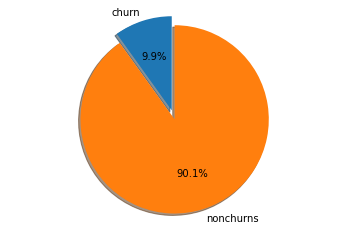

In [15]:
labels = ["churn","nonchurns"]
size = [df["churn"].value_counts()[1],df["churn"].value_counts()[0]]
explode = (0.1,0)
fig1,ax1 = plt.subplots()
ax1.pie(size,explode = explode,labels=labels,autopct = '%1.1f%%',shadow = True, startangle = 90)
ax1.axis('equal')#ensure aspect ratio ensures that pie is drawn a circle
plt.show()


In [16]:
# SME Activities
activities = df[['id','activity_new',"churn"]]
activities = activities.groupby([activities['activity_new'],activities['churn']])['id'].count().unstack(level=1).sort_values(by=[0])
activities

churn,0,1
activity_new,,
aacewucldmklslcffeckexipaemmsdfk,1.0,NaN
fuffsxwkckuoabdsallukmckpwlikakw,1.0,NaN
fwddlsxciofoefslfumfpxxmcomoaucd,1.0,NaN
fxocpcbfplipxiokscwiuexkceoucmko,1.0,NaN
ifdlbmlxdpwlpxkidiblliebeupwcaxu,1.0,NaN
...,...,...
opoiuuwdmxdssidluooopfswlkkkcsxf,NaN,1.0
pfcocskbxlmofswiflsbcefcpufbopuo,NaN,2.0
wceaopxmdpccxfmcdpopulcaubcxibuw,NaN,1.0


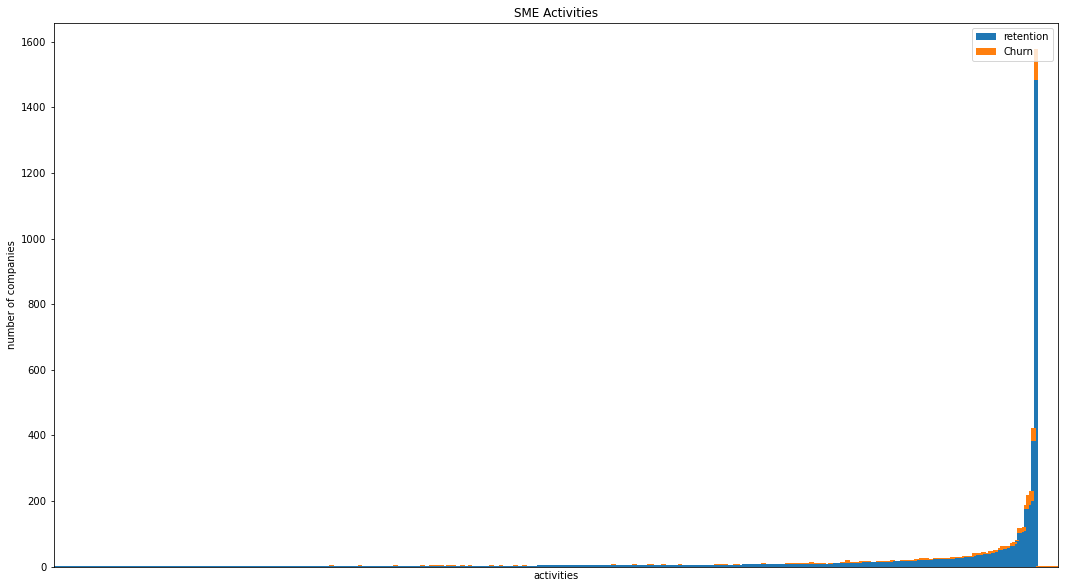

In [17]:
activities.plot(kind='bar',figsize =(18,10),width=2,stacked=True,title = 'SME Activities')
plt.ylabel("number of companies")
plt.xlabel("activities")
plt.legend(["retention","Churn"],loc = "upper right")
plt.xticks([])
plt.show()


## Data Cleaning

### Missing Value


There are 6 columns that have missing values more than 70% of the total column, so i decided to drop them.

In [18]:
df.drop(columns=['campaign_disc_ele',
'date_first_activ',
 'forecast_base_bill_ele',
 'forecast_base_bill_year',
 'forecast_bill_12m',
 'forecast_cons'],inplace =True)

In [19]:
pd.DataFrame({"df columns":df.columns})

,df columns
0,id
1,activity_new
2,channel_sales
3,cons_12m
4,cons_gas_12m
5,cons_last_month
6,date_activ
7,date_end
8,date_modif_prod
9,date_renewal


### Dropping duplicates

In [20]:
df.drop_duplicates()

,id,activity_new,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,48ada52261e7cf58715202705a0451c9,esoiiifxdlbkcsluxmfuacbdckommixw,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,2012-11-07,2016-11-06,2012-11-07,2015-11-09,...,f,831.80,-41.76,-41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.000,0
1,24011ae4ebbe3035111d65fa7c15bc57,NaN,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,NaN,2015-06-23,...,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
2,d29c2c54acc38ff3c0614d0a653813dd,NaN,NaN,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
3,764c75f661154dac3a6c254cd082ea7d,NaN,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
4,bba03439a292a1e166f80264c16191cb,NaN,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,...,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16091,18463073fb097fc0ac5d3e040f356987,NaN,foosdfpfkusacimwkcsosbicdxkicaua,32270,47940,0,2012-05-24,2016-05-08,2015-05-08,2014-05-26,...,t,0.00,27.88,27.88,2,381.77,4,lxidpiddsbxsbosboudacockeimpuepw,15.000,0
16092,d0a6f71671571ed83b2645d23af6de00,NaN,foosdfpfkusacimwkcsosbicdxkicaua,7223,0,181,2012-08-27,2016-08-27,2012-08-27,2015-08-28,...,f,15.94,0.00,0.00,1,90.34,3,lxidpiddsbxsbosboudacockeimpuepw,6.000,1
16093,10e6828ddd62cbcf687cb74928c4c2d2,NaN,foosdfpfkusacimwkcsosbicdxkicaua,1844,0,179,2012-02-08,2016-02-07,2012-02-08,2015-02-09,...,f,18.05,39.84,39.84,1,20.38,4,lxidpiddsbxsbosboudacockeimpuepw,15.935,1
16094,1cf20fd6206d7678d5bcafd28c53b4db,NaN,foosdfpfkusacimwkcsosbicdxkicaua,131,0,0,2012-08-30,2016-08-30,2012-08-30,2015-08-31,...,f,0.00,13.08,13.08,1,0.96,3,lxidpiddsbxsbosboudacockeimpuepw,11.000,0


### Missing dates

In [21]:
df.loc[df["date_modif_prod"].isnull(),"date_modif_prod"]=df["date_modif_prod"].value_counts().index[0]
df.loc[df["date_end"].isnull(),"date_end"]=df["date_end"].value_counts().index[0]
df.loc[df["date_renewal"].isnull(),"date_renewal"]=df["date_renewal"].value_counts().index[0]

### Missing data in history data


we dont have a lot of missing value in history data we can just replace the missing value with media or mean 

In [22]:
history_data.loc[history_data["price_p1_var"].isnull(),"price_p1_var"] = history_data['price_p1_var'].mean()
history_data.loc[history_data["price_p2_var"].isnull(),"price_p2_var"] = history_data['price_p2_var'].mean()
history_data.loc[history_data["price_p3_var"].isnull(),"price_p3_var"] = history_data['price_p3_var'].mean()
history_data.loc[history_data["price_p1_fix"].isnull(),"price_p1_fix"] = history_data['price_p1_fix'].mean()
history_data.loc[history_data["price_p2_fix"].isnull(),"price_p2_fix"] = history_data['price_p2_fix'].mean()
history_data.loc[history_data["price_p3_fix"].isnull(),"price_p3_fix"] = history_data['price_p3_fix'].mean()


### Change the format of dates

In [23]:
# Transform date columns to datetime type 
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d') 
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d') 
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d') 
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')   

In [24]:
history_data["price_date"] = pd.to_datetime(history_data["price_date"], format='%Y-%m-%d') 

### Deal with negative data



In [25]:
history_data.loc[history_data["price_p1_fix"]<0,"price_p1_fix"] = history_data['price_p1_fix'].median()
history_data.loc[history_data["price_p2_fix"]<0,"price_p2_fix"] = history_data['price_p2_fix'].median()
history_data.loc[history_data["price_p3_fix"]<0,"price_p3_fix"] = history_data['price_p3_fix'].median()


# 3.Feature Engineering


In [26]:
mean_year = history_data.groupby(['id']).mean().reset_index()
mean_year

,id,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.000000,0.000000,44.385450,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.000000,0.000000,45.319710,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.118757,0.098292,0.069032,40.647427,24.388455,16.258971
4,00114d74e963e47177db89bc70108537,0.147926,0.000000,0.000000,44.266930,0.000000,0.000000
...,...,...,...,...,...,...,...
16091,ffef185810e44254c3a4c6395e6b4d8a,0.138863,0.115125,0.080780,40.896427,24.637456,16.507972
16092,fffac626da707b1b5ab11e8431a4d0a2,0.147137,0.000000,0.000000,44.311375,0.000000,0.000000
16093,fffc0cacd305dd51f316424bbb08d1bd,0.153879,0.129497,0.094842,41.160171,24.895768,16.763569
16094,fffe4f5646aa39c7f97f95ae2679ce64,0.123858,0.103499,0.073735,40.606699,24.364017,16.242678


### Merge var and fix columns

In [27]:
mean_year = mean_year.rename(index=str, columns={"price_p1_var": "mean_year_price_p1_var",
"price_p2_var": "mean_year_price_p2_var",
"price_p3_var": "mean_year_price_p3_var",
"price_p1_fix": "mean_year_price_p1_fix",
"price_p2_fix": "mean_year_price_p2_fix",
"price_p3_fix": "mean_year_price_p3_fix",})
mean_year["mean_year_price_p1"] = mean_year["mean_year_price_p1_var"] + mean_year["mean_year_price_p1_fix"]
mean_year["mean_year_price_p2"] = mean_year["mean_year_price_p2_var"] + mean_year["mean_year_price_p2_fix"]
mean_year["mean_year_price_p3"] = mean_year["mean_year_price_p3_var"] + mean_year["mean_year_price_p3_fix"]

### Create a new column called tenure

In [28]:
df["tenure"] = ((df["date_end"]-df["date_activ"])/ np.timedelta64(1, "Y")).astype(int)
df["tenure"]

0        3
1        3
2        7
3        6
4        6
        ..
16091    3
16092    4
16093    3
16094    4
16095    6
Name: tenure, Length: 16096, dtype: int32

### Convert datetime to month for future process


In [29]:
def convert_months(reference_date, dataframe, column):
 """
 Input a column with timedeltas and return months
 """
 time_delta = REFERENCE_DATE - dataframe[column]
 months = (time_delta / np.timedelta64(1, "M")).astype(int)
 return months

# Create reference date as provided on the exercise statement
REFERENCE_DATE = datetime.datetime(2016,1,1)

df["months_activ"] = convert_months(REFERENCE_DATE, df, "date_activ")
df["months_to_end"] = -convert_months(REFERENCE_DATE, df, "date_end")
df["months_modif_prod"] = convert_months(REFERENCE_DATE, df, "date_modif_prod")
df["months_renewal"] = convert_months(REFERENCE_DATE, df, "date_renewal")
df["months_to_end"]

0        10
1         5
2         7
3         3
4         2
         ..
16091     4
16092     7
16093     1
16094     7
16095    11
Name: months_to_end, Length: 16096, dtype: int32

In [30]:
# drop these columns since we have already transformed them
df.drop(columns=["date_activ", "date_end", "date_modif_prod", "date_renewal"],inplace=True)

### Transfering boolean data to 1 and 0


In [31]:
df["has_gas"]=df["has_gas"].replace(["t", "f"],[1,0])


In [32]:
df['has_gas'].value_counts()

0    13132
1     2964
Name: has_gas, dtype: int64

### One hot encoding for categotical data

In [33]:
#First of all let's replace the Nan values with a string called null_values_channel
df["channel_sales"] = df["channel_sales"].fillna("null_values_channel")
# Transform to categorical data type
df["channel_sales"] = df["channel_sales"].astype("category")
pd.DataFrame({"Samples in category": df["channel_sales"].value_counts()})


,Samples in category
foosdfpfkusacimwkcsosbicdxkicaua,7377
null_values_channel,4218
lmkebamcaaclubfxadlmueccxoimlema,2073
usilxuppasemubllopkaafesmlibmsdf,1444
ewpakwlliwisiwduibdlfmalxowmwpci,966
sddiedcslfslkckwlfkdpoeeailfpeds,12
epumfxlbckeskwekxbiuasklxalciiuu,4
fixdbufsefwooaasfcxdxadsiekoceaa,2


In [34]:
# Create dummy variables
categories_channel = pd.get_dummies(df["channel_sales"], prefix = "channel")
categories_channel

,channel_epumfxlbckeskwekxbiuasklxalciiuu,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_fixdbufsefwooaasfcxdxadsiekoceaa,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_null_values_channel,channel_sddiedcslfslkckwlfkdpoeeailfpeds,channel_usilxuppasemubllopkaafesmlibmsdf
0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
16091,0,0,0,1,0,0,0,0
16092,0,0,0,1,0,0,0,0
16093,0,0,0,1,0,0,0,0
16094,0,0,0,1,0,0,0,0


In [35]:
# Rename columns for simplicity
categories_channel.columns = [col_name[:11] for col_name in categories_channel.columns]


In [36]:
categories_channel.head(5)

,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_nul,channel_sdd,channel_usi
0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0


In [37]:
#drop column which causes muticollinearity
categories_channel.drop(columns=["channel_nul"],inplace=True)


In [38]:
#perform the same step for other columns
df["origin_up"] = df["origin_up"].fillna("null_values_origin")
df["origin_up"] = df["origin_up"].astype("category")
# Create dummy variables
categories_origin = pd.get_dummies(df["origin_up"], prefix = "origin")
# Rename columns for simplicity
categories_origin.columns = [col_name[:10] for col_name in categories_origin.columns]
categories_origin.drop(columns=["origin_nul"],inplace=True)
categories_origin.head(5)

,origin_ewx,origin_kam,origin_ldk,origin_lxi,origin_usa
0,0,0,1,0,0
1,0,0,0,1,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0


In [39]:
#perform the same step for other columns
df["activity_new"] = df["activity_new"].fillna("null_values_activity")
# Get the categories with less than 75 samples
categories_activity = pd.DataFrame({"Activity samples":df["activity_new"].value_counts()})
categories_activity
to_replace = list(categories_activity[categories_activity["Activity samples"] <= 75].index)
# Replace them with `null_values_categories`
df["activity_new"]=df["activity_new"].replace(to_replace,"null_values_activity")
# Create dummy variables
categories_activity = pd.get_dummies(df["activity_new"], prefix = "activity")
# Rename columns for simplicity
categories_activity.columns = [col_name[:12] for col_name in categories_activity.columns]
categories_activity.head(5)


,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_nul,activity_sfi,activity_wxe
0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0


In [40]:
#drop the original column
categories_activity.drop(columns=["activity_nul"],inplace=True)

In [41]:
#Use common index to merge
df = pd.merge(df, categories_channel, left_index=True, right_index=True)
df = pd.merge(df, categories_origin, left_index=True, right_index=True)
df = pd.merge(df, categories_activity, left_index=True, right_index=True)

In [42]:
df.drop(columns=["channel_sales", "origin_up", "activity_new"],inplace=True)

### Log transformation


In [43]:
df.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,...,origin_usa,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_sfi,activity_wxe
count,1.609600e+04,1.609600e+04,1.609600e+04,16096.000000,16096.000000,15970.000000,16096.000000,15970.000000,15970.000000,15970.000000,...,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000
mean,1.948044e+05,3.191164e+04,1.946154e+04,2370.555949,1907.347229,0.991547,70.309945,0.135901,0.052951,43.533496,...,0.000124,0.097975,0.011742,0.007393,0.007580,0.013606,0.026218,0.014289,0.005157,0.007393
std,6.795151e+05,1.775885e+05,8.235676e+04,4035.085664,5257.364759,5.160969,79.023251,0.026252,0.048617,5.212252,...,0.011147,0.297290,0.107726,0.085668,0.086733,0.115852,0.159787,0.118684,0.071626,0.085668
min,-1.252760e+05,-3.037000e+03,-9.138600e+04,-16689.260000,-85627.000000,0.000000,-242.960000,0.000000,0.000000,-0.122184,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.906250e+03,0.000000e+00,0.000000e+00,513.230000,0.000000,0.000000,16.230000,0.115237,0.000000,40.606701,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.533250e+04,0.000000e+00,9.010000e+02,1179.160000,378.000000,0.000000,19.440000,0.142881,0.086163,44.311378,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.022150e+04,0.000000e+00,4.127000e+03,2692.077500,1994.250000,0.000000,131.470000,0.146348,0.098837,44.311378,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.609711e+07,4.188440e+06,4.538720e+06,103801.930000,175375.000000,50.000000,2411.690000,0.273963,0.195975,59.444710,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
# Remove negative values
df.loc[df.cons_12m < 0,"cons_12m"] = np.nan
df.loc[df.cons_gas_12m < 0,"cons_gas_12m"] = np.nan
df.loc[df.cons_last_month < 0,"cons_last_month"] = np.nan
df.loc[df.forecast_cons_12m < 0,"forecast_cons_12m"] = np.nan
df.loc[df.forecast_cons_year < 0,"forecast_cons_year"] = np.nan
df.loc[df.forecast_meter_rent_12m < 0,"forecast_meter_rent_12m"] = np.nan
df.loc[df.imp_cons < 0,"imp_cons"] = np.nan
# Apply log10 transformation
df["cons_12m"] = np.log10(df["cons_12m"]+1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"]+1)
df["cons_last_month"] = np.log10(df["cons_last_month"]+1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"]+1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"]+1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"]+1)
df["imp_cons"] = np.log10(df["imp_cons"]+1)

In [45]:
df.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,...,origin_usa,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_sfi,activity_wxe
count,16069.000000,16090.000000,16050.000000,16055.000000,16071.000000,15970.000000,16092.000000,15970.000000,15970.000000,15970.000000,...,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000
mean,4.283812,0.800300,2.359281,3.006826,1.869956,0.991547,1.549610,0.135901,0.052951,43.533496,...,0.000124,0.097975,0.011742,0.007393,0.007580,0.013606,0.026218,0.014289,0.005157,0.007393
std,0.915265,1.748833,1.789067,0.709778,1.612963,5.160969,0.589394,0.026252,0.048617,5.212252,...,0.011147,0.297290,0.107726,0.085668,0.086733,0.115852,0.159787,0.118684,0.071626,0.085668
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.122184,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.773786,0.000000,0.000000,2.713952,0.000000,0.000000,1.236285,0.115237,0.000000,40.606701,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.187408,0.000000,2.959041,3.073579,2.583199,0.000000,1.310481,0.142881,0.086163,44.311378,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.701508,0.000000,3.617000,3.430950,3.301030,0.000000,2.122126,0.146348,0.098837,44.311378,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.206748,6.622052,6.656933,5.016210,5.243970,50.000000,3.382502,0.273963,0.195975,59.444710,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Use heatmap to select features

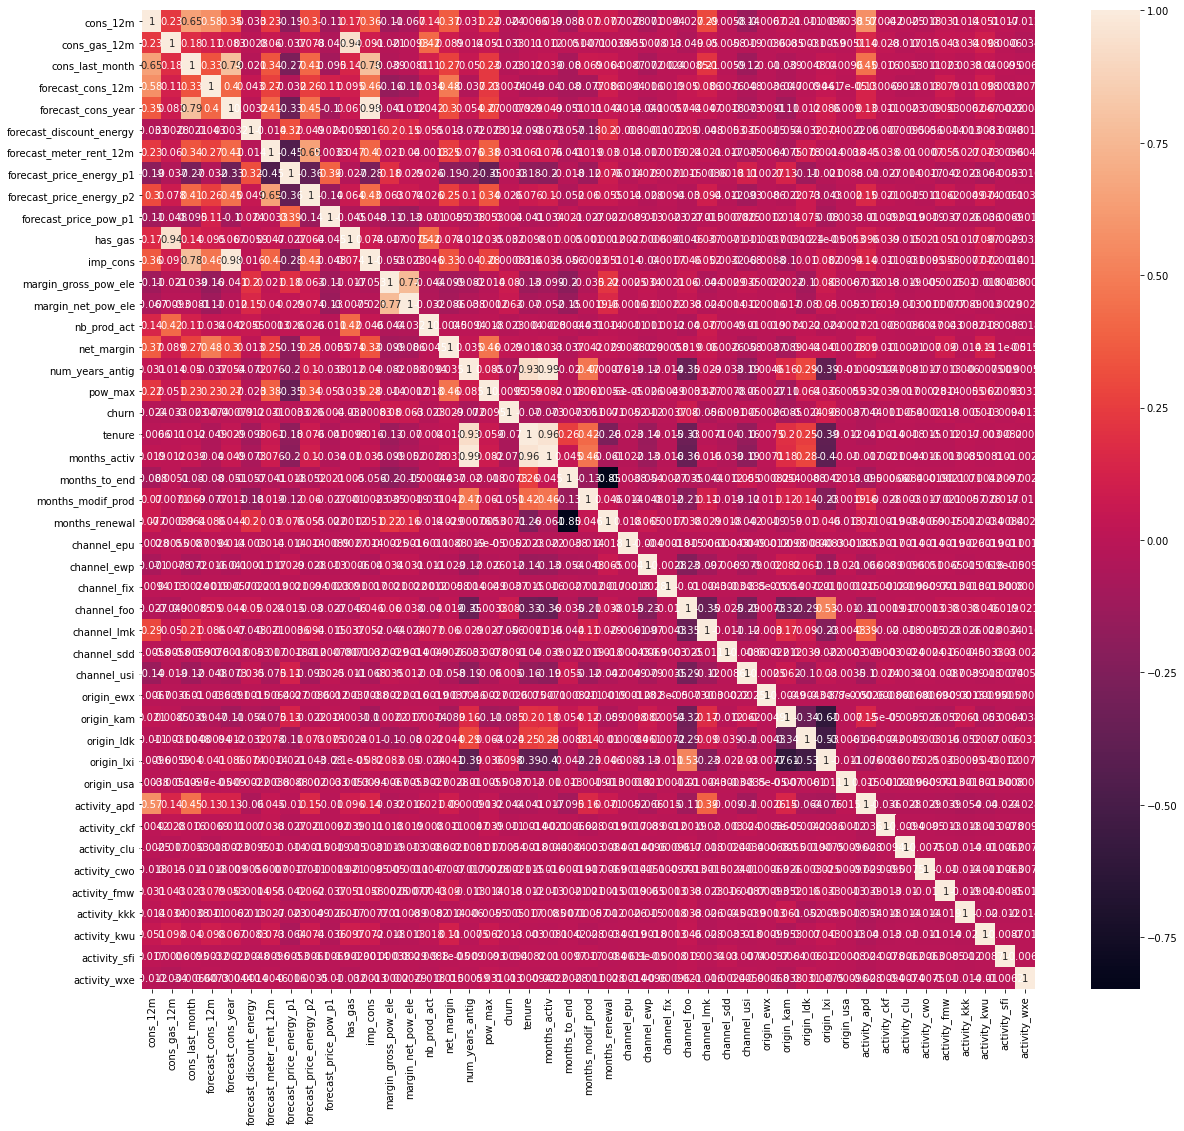

In [46]:
# Calculate correlation of variables
correlation = df.corr()
# Plot correlation
plt.figure(figsize=(20,18))
sns.heatmap(correlation, xticklabels=correlation.columns.values,
 yticklabels=correlation.columns.values, annot = True, annot_kws={'size':10})
# Axis ticks size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [47]:
df.drop(columns=["num_years_antig", "forecast_cons_year"],inplace=True)

In [48]:
def replace_outliers_z_score(dataframe, column, Z=3):
 """
 Replace outliers with the mean values using the Z score.
 Nan values are also replaced with the mean values.
 Parameters
 ----------
 dataframe : pandas dataframe
 Contains the data where the outliers are to be found
 column : str
 Usually a string with the name of the column

 Returns
 -------
 Dataframe
 With outliers under the lower and above the upper bound removed
 """
 from scipy.stats import zscore

 df = dataframe.copy(deep=True)
 df.dropna(inplace=True, subset=[column])

 # Calculate mean without outliers
 df["zscore"] = zscore(df[column])
 mean_ = df[(df["zscore"] > -Z) & (df["zscore"] < Z)][column].mean()

 # Replace with mean values
 dataframe[column] = dataframe[column].fillna(mean_)
 dataframe["zscore"] = zscore(dataframe[column])
 no_outliers = dataframe[(dataframe["zscore"] < -Z) | (dataframe["zscore"] > Z)].shape[0]
 dataframe.loc[(dataframe["zscore"] < -Z) | (dataframe["zscore"] > Z),column] = mean_

# Print message
 print("Replaced:", no_outliers, " outliers in ", column)
 return dataframe.drop(columns="zscore")


In [49]:
def _find_outliers_iqr(dataframe, column):
 """
 Find outliers using the 1.5*IQR rule.
 Parameters
 ----------
 dataframe : pandas dataframe
 Contains the data where the outliers are to be found
 column : str
 Usually a string with the name of the column

 Returns
 -------
 Dict
 With the values of the iqr, lower_bound and upper_bound
 """
 col = sorted(dataframe[column])
 q1, q3= np.percentile(col,[25,75])
 iqr = q3 - q1
 lower_bound = q1 -(1.5 * iqr)
 upper_bound = q3 +(1.5 * iqr)
 results = {"iqr": iqr, "lower_bound":lower_bound, "upper_bound":upper_bound}
 return results
def remove_outliers_iqr(dataframe, column):
 """
 Remove outliers using the 1.5*IQR rule.
 Parameters
 ----------
 dataframe : pandas dataframe
 Contains the data where the outliers are to be found
 column : str
 Usually a string with the name of the column

 Returns
 -------
 Dataframe
 With outliers under the lower and above the upper bound removed
 """

 outliers = _find_outliers_iqr(dataframe, column)
 removed = dataframe[(dataframe[column] < outliers["lower_bound"]) |
 (dataframe[column] > outliers["upper_bound"])].shape

 dataframe = dataframe[(dataframe[column] > outliers["lower_bound"]) &
 (dataframe[column] < outliers["upper_bound"])]
 print("Removed:", removed[0], " outliers")
 return dataframe
def remove_outliers_z_score(dataframe, column, Z=3):
 """
 Remove outliers using the Z score. Values with more than 3 are removed.
 Parameters
 ----------
 dataframe : pandas dataframe
 Contains the data where the outliers are to be found
 column : str
 Usually a string with the name of the column

 Returns
 -------
 Dataframe
 With outliers under the lower and above the upper bound removed
 """
 from scipy.stats import zscore

 dataframe["zscore"] = zscore(dataframe[column])

 removed = dataframe[(dataframe["zscore"] < -Z) |
 (dataframe["zscore"] > Z)].shape

 dataframe = dataframe[(dataframe["zscore"] > -Z) &
 (dataframe["zscore"] < Z)]

 print("Removed:", removed[0], " outliers of ", column)

 return dataframe.drop(columns="zscore")
def replace_outliers_z_score(dataframe, column, Z=3):
 """
 Replace outliers with the mean values using the Z score.
 Nan values are also replaced with the mean values.
 Parameters
 ----------
 dataframe : pandas dataframe
 Contains the data where the outliers are to be found
 column : str
 Usually a string with the name of the column

 Returns
 -------
 Dataframe
 With outliers under the lower and above the upper bound removed
 """
 from scipy.stats import zscore

 df = dataframe.copy(deep=True)
 df.dropna(inplace=True, subset=[column])

 # Calculate mean without outliers
 df["zscore"] = zscore(df[column])
 mean_ = df[(df["zscore"] > -Z) & (df["zscore"] < Z)][column].mean()

 # Replace with mean values
 no_outliers = dataframe[column].isnull().sum()
 dataframe[column] = dataframe[column].fillna(mean_)
 dataframe["zscore"] = zscore(dataframe[column])
 dataframe.loc[(dataframe["zscore"] < -Z) | (dataframe["zscore"] > Z),column] = mean_

 # Print message
 print("Replaced:", no_outliers, " outliers in ", column)
 return dataframe.drop(columns="zscore")


In [50]:
df = replace_outliers_z_score(df,"cons_12m")
df = replace_outliers_z_score(df,"cons_gas_12m")
df = replace_outliers_z_score(df,"cons_last_month")
df = replace_outliers_z_score(df,"forecast_cons_12m")
#train = replace_outliers_z_score(train,"forecast_cons_year")
df = replace_outliers_z_score(df,"forecast_discount_energy")
df = replace_outliers_z_score(df,"forecast_meter_rent_12m")
df = replace_outliers_z_score(df,"forecast_price_energy_p1")
df = replace_outliers_z_score(df,"forecast_price_energy_p2")
df = replace_outliers_z_score(df,"forecast_price_pow_p1")
df = replace_outliers_z_score(df,"imp_cons")
df = replace_outliers_z_score(df,"margin_gross_pow_ele")
df = replace_outliers_z_score(df,"margin_net_pow_ele")
df = replace_outliers_z_score(df,"net_margin")
df = replace_outliers_z_score(df,"pow_max")
df = replace_outliers_z_score(df,"months_activ")
df = replace_outliers_z_score(df,"months_to_end")
df = replace_outliers_z_score(df,"months_modif_prod")
df = replace_outliers_z_score(df,"months_renewal")


Replaced: 27  outliers in  cons_12m
Replaced: 6  outliers in  cons_gas_12m
Replaced: 46  outliers in  cons_last_month
Replaced: 41  outliers in  forecast_cons_12m
Replaced: 126  outliers in  forecast_discount_energy
Replaced: 4  outliers in  forecast_meter_rent_12m
Replaced: 126  outliers in  forecast_price_energy_p1
Replaced: 126  outliers in  forecast_price_energy_p2
Replaced: 126  outliers in  forecast_price_pow_p1
Replaced: 27  outliers in  imp_cons
Replaced: 13  outliers in  margin_gross_pow_ele
Replaced: 13  outliers in  margin_net_pow_ele
Replaced: 15  outliers in  net_margin
Replaced: 3  outliers in  pow_max
Replaced: 0  outliers in  months_activ
Replaced: 0  outliers in  months_to_end
Replaced: 0  outliers in  months_modif_prod
Replaced: 0  outliers in  months_renewal


# 4.Model selection and building 

In [51]:
train = pd.merge(df, history_data, on="id")
pd.DataFrame({"Dataframe columns": train.columns})

,Dataframe columns
0,id
1,cons_12m
2,cons_gas_12m
3,cons_last_month
4,forecast_cons_12m
5,forecast_discount_energy
6,forecast_meter_rent_12m
7,forecast_price_energy_p1
8,forecast_price_energy_p2
9,forecast_price_pow_p1


In [52]:
train.drop(columns=["price_date"],inplace=True)

In [53]:
#split the dateset into testing and training
y = train["churn"]
x = train.drop(labels = ["id","churn"],axis = 1)

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

### Modeling

In [55]:
#Logistic Regression
LR_model = LogisticRegression(multi_class = 'auto',max_iter =10000)
Lr_result =LR_model.fit(x_train,y_train)

In [56]:
#XGBoost
XGB_model = xgb.XGBClassifier(learning_rate=0.1,max_depth=6,n_estimators=500,n_jobs=-1)
XGB_result = XGB_model.fit(x_train,y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[21:40:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [57]:
#RandomForest Classifier
clf = RandomForestClassifier(n_estimators = 100,max_depth =15,random_state = 0)
clf_result = clf.fit(x_train,y_train)

In [58]:
def evaluate(model_, X_test_, y_test_):
 """
 Evaluate the accuracy, precision and recall of a model
 """

 # Get the model predictions
 prediction_test_ = model_.predict(X_test_)

 # Print the evaluation metrics as pandas dataframe
 results = pd.DataFrame({"Accuracy" : [metrics.accuracy_score(y_test_, prediction_test_)],
 "Precision" : [metrics.precision_score(y_test_, prediction_test_)],
 "Recall" : [metrics.recall_score(y_test_, prediction_test_)]})

 # For a more detailed report
 #print(metrics.classification_report(y_test_, prediction_test_))
 return results

In [59]:
#Model Evaluation
lr_evaluation = evaluate(LR_model, x_test, y_test)
XGB_evaluation = evaluate(XGB_model, x_test, y_test)
clf_evaluation = evaluate(clf, x_test, y_test)

In [60]:
final_result = pd.concat([lr_evaluation,XGB_evaluation])
final_result =pd.concat([final_result,clf_evaluation])
model_name = ['Logistic Regression','XGBoost','RandomForest']
final_result.insert(loc = 0,column = 'Model', value = model_name)
final_result

,Model,Accuracy,Precision,Recall
0,Logistic Regression,0.898733,0.541667,0.003324
0,XGBoost,0.980285,0.999049,0.806188
0,RandomForest,0.947178,1.000000,0.478650


In [61]:
def calculate_roc_auc(model_, X_test_, y_test_):
 """
 Evaluate the roc-auc score
 """

 # Get the model predictions
 # Note that we are using the prediction for the class 1 -> churn
 prediction_test_ = model_.predict_proba(X_test_)[:,1]
 # Compute roc-auc
 fpr, tpr, thresholds = metrics.roc_curve(y_test_, prediction_test_)

 # Print the evaluation metrics as pandas dataframe
 score = pd.DataFrame({"ROC-AUC" : [metrics.auc(fpr, tpr)]})
 return fpr, tpr, score
def plot_roc_auc(fpr,tpr):
 """
 Plot the Receiver Operating Characteristic from a list
 of true positive rates and false positive rates.
 """

 # Initialize plot
 f, ax = plt.subplots(figsize=(14,8))

 # Plot ROC
 roc_auc = metrics.auc(fpr, tpr)
 ax.plot(fpr, tpr, lw=2, alpha=0.3,
 label="AUC = %0.2f" % (roc_auc))
 # Plot the random line.
 plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
 label="Random", alpha=.8)

 # Fine tune and show the plot.
 ax.set_xlim([-0.05, 1.05])
 ax.set_ylim([-0.05, 1.05])
 ax.set_xlabel("False Positive Rate (FPR)")
 ax.set_ylabel("True Positive Rate (TPR)")
 ax.set_title("ROC-AUC")
 ax.legend(loc="lower right")
 plt.show()


In [62]:
fpr, tpr, auc_score = calculate_roc_auc(XGB_model, x_test, y_test)
auc_score

,ROC-AUC
0,0.999445


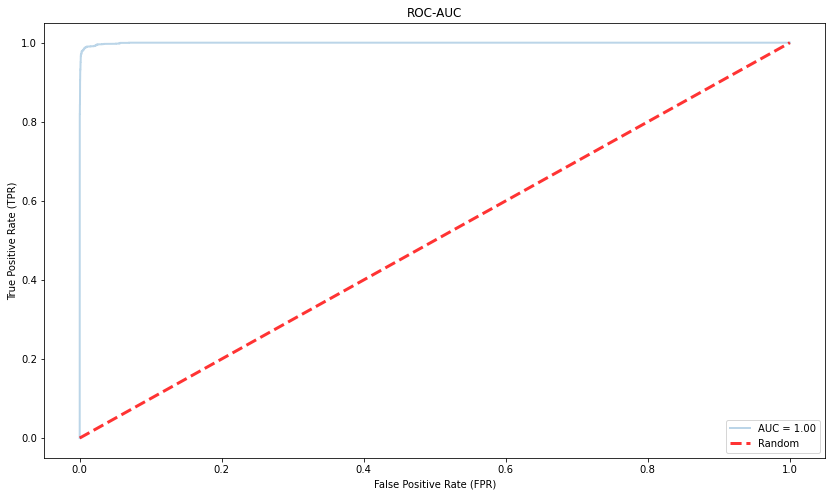

In [63]:
plot_roc_auc(fpr, tpr)
plt.show()

### Model fine tuning 

In [80]:
def plot_roc_curve(fprs, tprs):
 """
 Plot the Receiver Operating Characteristic from a list
 of true positive rates and false positive rates.
 """

 # Initialize useful lists + the plot axes.
 tprs_interp = []
 aucs = []
 mean_fpr = np.linspace(0, 1, 100)
 f, ax = plt.subplots(figsize=(18,10))

 # Plot ROC for each K-Fold + compute AUC scores.
 for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        
     tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
     tprs_interp[-1][0] = 0.0
     roc_auc = metrics.auc(fpr, tpr)
     aucs.append(roc_auc)
     ax.plot(fpr, tpr, lw=2, alpha=0.3,
     label="ROC fold %d (AUC = %0.2f)" % (i, roc_auc))

 # Plot the luck line.
 plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
 label="Random", alpha=.8)

 # Plot the mean ROC.
 mean_tpr = np.mean(tprs_interp, axis=0)
 mean_tpr[-1] = 1.0
 mean_auc = metrics.auc(mean_fpr, mean_tpr)
 std_auc = np.std(aucs)
 ax.plot(mean_fpr, mean_tpr, color='b',
 label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
 lw=4, alpha=.8)

 # Plot the standard deviation around the mean ROC.
 std_tpr = np.std(tprs_interp, axis=0)
 tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
 tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
 ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=.2,
 label=r"$\pm$ 1 std. dev.")

 # Fine tune and show the plot.
 ax.set_xlim([-0.05, 1.05])
 ax.set_ylim([-0.05, 1.05])
 ax.set_xlabel("False Positive Rate (FPR)")
 ax.set_ylabel("True Positive Rate (TPR)")
 ax.set_title("ROC-AUC")
 ax.legend(loc="lower right")
 plt.show()
 return (f, ax)
def compute_roc_auc(model_, index):
 y_predict = model_.predict_proba(x.iloc[index])[:,1]
 fpr, tpr, thresholds = metrics.roc_curve(y.iloc[index], y_predict)
 auc_score = metrics.auc(fpr, tpr)
 return fpr, tpr, auc_score

In [64]:
from sklearn.model_selection import RandomizedSearchCV
# Create the random grid
params = {
 'min_child_weight': [i for i in np.arange(1,15,1)],
 'gamma': [i for i in np.arange(0,6,0.5)],
 'subsample': [i for i in np.arange(0,1.1,0.1)],
 'colsample_bytree': [i for i in np.arange(0,1.1,0.1)],
 'max_depth': [i for i in np.arange(1,15,1)],
 'scale_pos_weight':[i for i in np.arange(1,15,1)],
 'learning_rate': [i for i in np.arange(0,0.15,0.01)],
'n_estimators' : [i for i in np.arange(0,2000,100)]
 }


In [65]:
# Create model
xg = xgb.XGBClassifier(objective='binary:logistic',
 silent=True, nthread=1)

In [66]:
# Random search of parameters, using 5
xg_random = RandomizedSearchCV(xg, param_distributions=params,
 n_iter=1, scoring= "roc_auc",
 n_jobs=4, cv=5, verbose=3, random_state=1001)
# Fit the random search model
xg_random.fit(x_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:   20.2s remaining:   30.3s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   33.6s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[21:42:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:42:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                        'min_child_weight': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                        

In [67]:
best_random = xg_random.best_params_
best_random

{'subsample': 0.0,
 'scale_pos_weight': 6,
 'n_estimators': 300,
 'min_child_weight': 10,
 'max_depth': 12,
 'learning_rate': 0.1,
 'gamma': 2.5,
 'colsample_bytree': 1.0}

In [68]:
best_random = {'subsample': 0,
'scale_pos_weight': 6,
'n_estimators': 300,
'min_child_weight': 10,
'max_depth': 12,
'learning_rate': 0.1,
'gamma': 2.5,
'colsample_bytree': 1.0}

In [71]:
# Create a model with the parameters found
model_random = xgb.XGBClassifier(objective='binary:logistic',
 silent=True, nthread=1, **best_random)
fprs, tprs, scores = [], [], []
cv = StratifiedKFold(n_splits=5, random_state=13, shuffle=True)

In [81]:
for (train, test), i in zip(cv.split(x, y), range(5)):
 model_random.fit(x.iloc[train], y.iloc[train])
 _, _, auc_score_train = compute_roc_auc(model_random, train)
 fpr, tpr, auc_score = compute_roc_auc(model_random, test)
 scores.append((auc_score_train, auc_score))
 fprs.append(fpr)
 tprs.append(tpr)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[21:54:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:54:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:54:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip

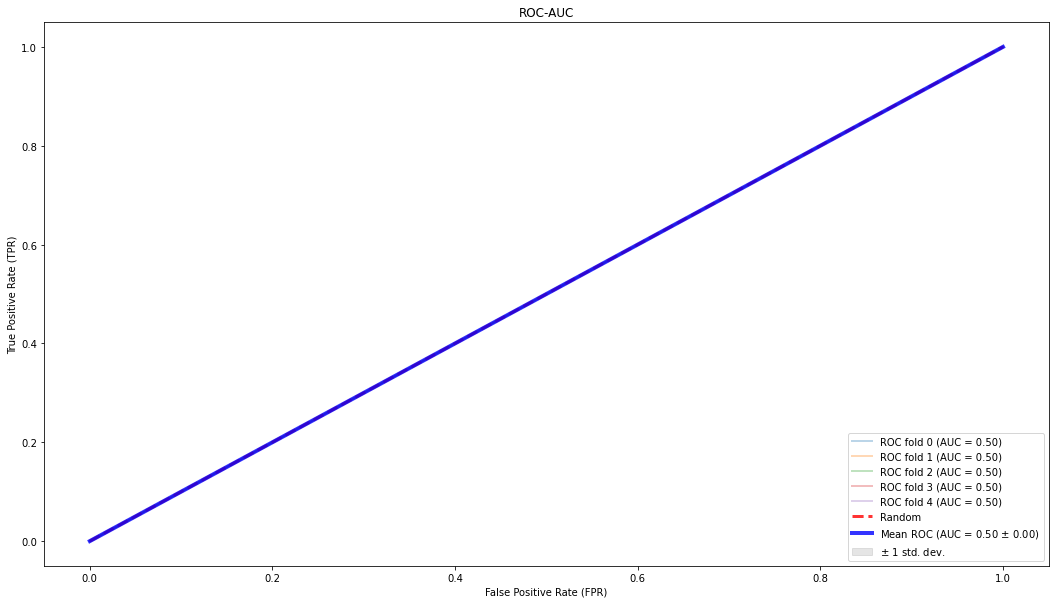

In [82]:
plot_roc_curve(fprs, tprs)
plt.show()